<a href="https://colab.research.google.com/github/akshaypat444/tensorflow_practice/blob/main/SkimLit_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

## Get the data (PUBMED DATASET)

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 15.62 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess Data

In [6]:
def get_lines(filename):
  """
    Reads the file name and returns the
    lines of text as a list.
  """

  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(filenames[2])
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"): # Start of the new abstract
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstract
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [9]:
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

In [10]:
%%time
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


(180040, 30212, 30135)

In [11]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [12]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [13]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [14]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# One hot encode labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_label_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Encode Lables

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())

In [17]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Create Baseline Model

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
# Evaluate
model_0.score(X=val_sentences,
                y=val_labels_encoded)

0.7218323844829869

In [21]:
# Make predictions using out baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-04 18:56:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-04 18:56:35 (68.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:
from helper_functions import calculate_results

In [24]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 1
* Preparing data for deep sequence model
1. Create vectorization layer
2. Create embedding layers

In [25]:
from tensorflow.keras import layers

In [26]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

In [27]:
import matplotlib.pyplot as plt

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

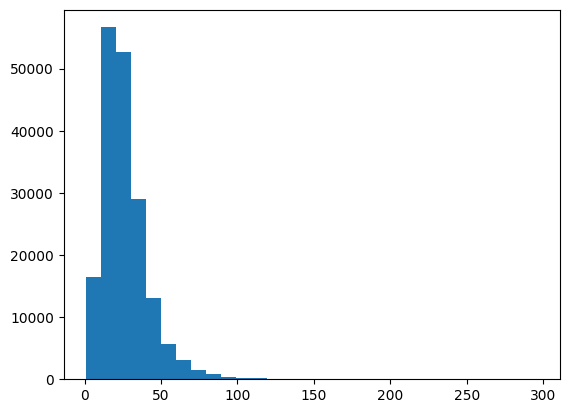

In [28]:
plt.hist(sent_lens, bins=30)

In [29]:
# How long of a sentence length covers 95% of example?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
# 95% of the sentences are under length 55

### Model 1: Text Vectorization (Tokenization)
* Tokenization is direct mapping from token to numbers

In [31]:
max_vocab_length = 68000 # max number of words to have in vocabulary
max_length = output_seq_len

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                               output_mode='int',
                                               output_sequence_length=max_length)

# Without adapt method or fitting the train_sentences the text_vectorization layer won't work
# On input sentences
train_vectorized = text_vectorizer.adapt(train_sentences)

In [32]:
import random
target_sentence = random.choice(train_sentences)
print(f"{len(target_sentence.split())}")
print(f"{target_sentence}")
x = text_vectorizer([target_sentence])
print(f"{x}")

22
one group received a @-day regimen of oral amoxicillin ( @ mg/kg/day ) postoperatively and the other group received placebo medication .
[[  88   13   80    8  108  576    4  217 3125 3810  721    3    2  168
    13   80   48  320    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [33]:
len(text_vectorizer.get_vocabulary())

64841

### Model 1: Text Embedding

In [34]:
embedding_layer = tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),
                                            output_dim=128,
                                            input_length=output_seq_len,
                                            mask_zero=True)

In [35]:
embedding_layer

In [36]:
y = embedding_layer(text_vectorizer([train_sentences[0]]))
y

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.00620421, -0.00388896, -0.04047277, ..., -0.03848442,
         -0.03852904, -0.04038636],
        [-0.00212449, -0.00666583, -0.00695487, ...,  0.01896801,
          0.02268815,  0.00911137],
        [ 0.0373757 ,  0.04543393, -0.00864921, ...,  0.03534843,
          0.01243267, -0.00165075],
        ...,
        [ 0.02190134,  0.00126585,  0.00685408, ...,  0.0482028 ,
         -0.04399763, -0.04258141],
        [ 0.02190134,  0.00126585,  0.00685408, ...,  0.0482028 ,
         -0.04399763, -0.04258141],
        [ 0.02190134,  0.00126585,  0.00685408, ...,  0.0482028 ,
         -0.04399763, -0.04258141]]], dtype=float32)>

### Creating tensorflow datasets for model
* This loads the data faster because of tf dataset apis internal optimizations

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_label_one_hot))

### Create datasets into prefetched datasets

In [38]:
# Shuffle is not used here because we want to preserve the sequence of sentences for task
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Conv1D Model with token embedding

In [39]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = embedding_layer(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [40]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 325   

In [41]:
history_model_1 = model_1.fit(train_dataset, epochs=5, steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset))
                              )

Epoch 1/5
562/562 [==============================] - 21s 31ms/step - loss: 0.9175 - accuracy: 0.6383 - val_loss: 0.6785 - val_accuracy: 0.7430
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.6512 - accuracy: 0.7591 - val_loss: 0.6262 - val_accuracy: 0.7743
Epoch 3/5
562/562 [==============================] - 4s 7ms/step - loss: 0.6131 - accuracy: 0.7762 - val_loss: 0.5931 - val_accuracy: 0.7829
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5861 - accuracy: 0.7899 - val_loss: 0.5764 - val_accuracy: 0.7886
Epoch 5/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5895 - accuracy: 0.7931 - val_loss: 0.5590 - val_accuracy: 0.7962


In [42]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5595 - accuracy: 0.8017


[0.5594949126243591, 0.8017013072967529]

In [43]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[5.2549094e-01, 1.7397331e-01, 4.2505886e-02, 1.8725756e-01,
         7.0772305e-02],
        [4.5801714e-01, 3.2415175e-01, 2.8269151e-02, 1.4154974e-01,
         4.8012253e-02],
        [1.5985417e-01, 4.0848497e-03, 1.4047778e-03, 8.3460808e-01,
         4.8107286e-05],
        ...,
        [5.2586500e-05, 5.6551612e-04, 4.4089383e-03, 4.6024059e-05,
         9.9492693e-01],
        [9.4427496e-02, 3.0231160e-01, 1.2810843e-01, 6.3637480e-02,
         4.1151491e-01],
        [1.5181099e-01, 7.5882816e-01, 5.8679149e-02, 1.3076211e-02,
         1.7605502e-02]], dtype=float32),
 (30212, 5))

In [44]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [45]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.17013107374554,
 'precision': 0.8016035319359976,
 'recall': 0.8017013107374553,
 'f1': 0.7986789367280132}

### Tensorflow Hub Pretrained Feature Extractor

In [46]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [47]:
# Test our pretrained embeddings
random_training_sentence = random.choice(train_sentences)
print(f"Random sentence: {random_training_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding: {use_embedded_sentence[0][:30]}")

Random sentence: secondary outcome measures are ( @ ) change in severity of behavioural symptoms , as measured by the npi-q at @ months ( to ensure antipsychotic reduction has not lead to worsening behavioural symptoms ) , and ( @ ) proportion of people with hd who have had a reduction in antipsychotic dosage at @ months for each strategy , compared to @ months prior to enrolment ( to capture the possibility that both arms reduced antipsychotic use ) .
Sentence after embedding: [ 0.00762062 -0.03587729 -0.04958393 -0.07015474 -0.06269636  0.05953803
  0.0375871  -0.04658015 -0.00367254  0.02715185  0.07790009 -0.04644279
  0.04808055  0.04119895  0.05097995 -0.04315063 -0.07809255 -0.06659613
  0.02603401  0.01787907 -0.07152429  0.04551397 -0.02806167 -0.01408428
  0.00285701  0.05234771  0.0749122   0.0149732  -0.0589286   0.0064117 ]


In [48]:
use_embedded_sentence.shape

TensorShape([1, 512])

In [49]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_model_2 = model_2.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 10s 13ms/step - loss: 0.9166 - accuracy: 0.6491 - val_loss: 0.7947 - val_accuracy: 0.6902
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7663 - accuracy: 0.7037 - val_loss: 0.7522 - val_accuracy: 0.7061
Epoch 3/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7479 - accuracy: 0.7144 - val_loss: 0.7356 - val_accuracy: 0.7168
Epoch 4/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7146 - accuracy: 0.7251 - val_loss: 0.7075 - val_accuracy: 0.7291
Epoch 5/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7223 - accuracy: 0.7227 - val_loss: 0.6885 - val_accuracy: 0.7344


In [50]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.6949 - accuracy: 0.7347


[0.6948734521865845, 0.7347411513328552]

### Observe the trainable parameters in both models

In [51]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 325   

In [52]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [53]:
model_2_preds_probs = model_2.predict(val_dataset)
model_2_preds_probs

945/945 [==============================] - 10s 10ms/step


array([[6.29657090e-01, 2.39082426e-01, 2.71954504e-03, 1.18385680e-01,
        1.01551944e-02],
       [4.43508983e-01, 4.58448589e-01, 6.42508548e-03, 8.82231295e-02,
        3.39422678e-03],
       [4.11691636e-01, 5.94848245e-02, 4.70864996e-02, 4.43152308e-01,
        3.85847017e-02],
       ...,
       [1.42676383e-03, 2.82308832e-03, 1.04769394e-01, 5.91192162e-04,
        8.90389502e-01],
       [2.53105583e-03, 2.31811535e-02, 4.79027808e-01, 8.75548751e-04,
        4.94384408e-01],
       [1.72767967e-01, 3.73507172e-01, 4.05681759e-01, 3.46349343e-03,
        4.45796065e-02]], dtype=float32)

In [54]:
model_2_preds_probs.shape

(30212, 5)

In [55]:
model_2_preds = tf.argmax(model_2_preds_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [56]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 73.47411624520058,
 'precision': 0.7309378377716462,
 'recall': 0.7347411624520058,
 'f1': 0.7289248498575474}

## Conv1D with Character embeddings

In [57]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

's e c o n d a r y   o u t c o m e   m e a s u r e s   a r e   (   @   )   c h a n g e   i n   s e v e r i t y   o f   b e h a v i o u r a l   s y m p t o m s   ,   a s   m e a s u r e d   b y   t h e   n p i - q   a t   @   m o n t h s   (   t o   e n s u r e   a n t i p s y c h o t i c   r e d u c t i o n   h a s   n o t   l e a d   t o   w o r s e n i n g   b e h a v i o u r a l   s y m p t o m s   )   ,   a n d   (   @   )   p r o p o r t i o n   o f   p e o p l e   w i t h   h d   w h o   h a v e   h a d   a   r e d u c t i o n   i n   a n t i p s y c h o t i c   d o s a g e   a t   @   m o n t h s   f o r   e a c h   s t r a t e g y   ,   c o m p a r e d   t o   @   m o n t h s   p r i o r   t o   e n r o l m e n t   (   t o   c a p t u r e   t h e   p o s s i b i l i t y   t h a t   b o t h   a r m s   r e d u c e d   a n t i p s y c h o t i c   u s e   )   .'

In [58]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [59]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [63]:
chars_length = [len(sentence) for sentence in train_sentences]
mean_chars_length = np.mean(chars_length)
mean_chars_length

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <BarContainer object of 20 artists>)

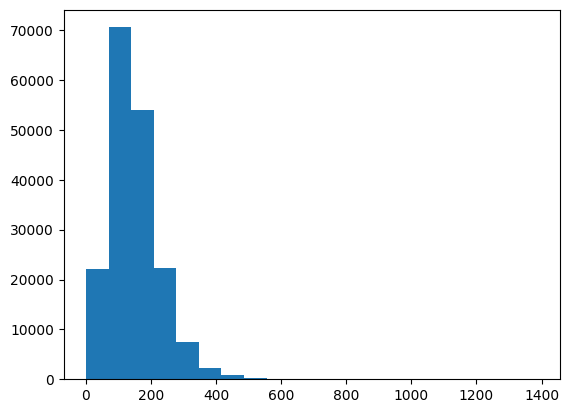

In [65]:
import matplotlib.pyplot as plt

plt.hist(chars_length, bins=20)

In [67]:
output_seq_char_len = np.percentile(chars_length, 95)

In [68]:
output_seq_char_len

290.0

In [69]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
len(alphabet)

68

In [71]:
MAX_CHAR_TOKENS = len(alphabet) + 2 # for padding and unknown token
char_vectorizer = layers.TextVectorization(max_tokens=MAX_CHAR_TOKENS,
                                             output_sequence_length=int(output_seq_char_len),
                                             standardize="lower_and_strip_punctuation",
                                             name="char_vectorizer",
                                           )

In [72]:
char_vectorizer.adapt(train_chars)

In [118]:
char_vocabs = char_vectorizer.get_vocabulary()
print(x)

['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's', 'd', 'c', 'l', 'h', 'p', 'm', 'u', 'f', 'g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']


In [111]:
char_vectorizer(random.choice(train_chars))

<tf.Tensor: shape=(290,), dtype=int64, numpy=
array([ 3, 13,  2,  7, 22, 27,  2, 11,  3,  4, 21,  2,  7, 17,  3, 13,  4,
        9, 14,  4, 12,  7,  3,  8,  5,  6, 10,  7, 15,  4, 25,  2, 10, 11,
       12,  4,  6,  4, 11,  5, 12,  3,  8,  4,  5, 12, 20,  5,  9,  3,  7,
        4,  6, 21,  2,  9,  3,  4, 18,  5,  3,  2, 20, 13,  2,  3, 13,  2,
        8,  5, 22,  5, 12,  5,  6, 11,  2,  3,  8,  5,  4,  6,  4,  6, 18,
       14,  8,  7, 18,  8,  5, 15, 16,  9,  4,  6, 18,  5, 16, 18, 15,  2,
        6,  3,  2, 10, 21,  4,  9, 16,  5, 12, 17,  2,  2, 10, 22,  5, 11,
       23,  4,  9, 17,  2,  5,  9,  4, 22, 12,  2,  9,  5, 17,  2,  5,  6,
       10, 15,  7,  8,  2,  2, 17, 17,  2, 11,  3,  4, 21,  2,  3, 13,  5,
        6, 11,  7,  6, 21,  2,  6,  3,  4,  7,  6,  5, 12, 22,  5, 12,  5,
        6, 11,  2,  3,  8,  5,  4,  6,  4,  6, 18,  4,  6,  4, 15, 14,  8,
        7, 21,  4,  6, 18, 14,  7,  9,  3, 16,  8,  5, 12, 11,  7,  6,  3,
        8,  7, 12,  4,  6, 14,  5,  3,  4,  2,  6,  3,

In [109]:
len(char_vectorizer(random.choice(train_chars)))

290

In [119]:
embedding_char = layers.Embedding(input_dim=len(char_vocabs),
                                  output_dim=25,
                                  mask_zero=False,
                                  name="char_embedding")

In [126]:
x_embedding = embedding_char(char_vectorizer([random.choice(train_chars)]))

In [127]:
x_embedding

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[-0.02484988,  0.01345119, -0.03429163, ...,  0.02833444,
         -0.00533347,  0.03386276],
        [-0.00448453, -0.02838653,  0.04354396, ..., -0.03095565,
          0.02973241, -0.03942364],
        [-0.02484988,  0.01345119, -0.03429163, ...,  0.02833444,
         -0.00533347,  0.03386276],
        ...,
        [ 0.01475862, -0.04181068, -0.03938763, ...,  0.04931996,
          0.03633671,  0.02081957],
        [ 0.01475862, -0.04181068, -0.03938763, ...,  0.04931996,
          0.03633671,  0.02081957],
        [ 0.01475862, -0.04181068, -0.03938763, ...,  0.04931996,
          0.03633671,  0.02081957]]], dtype=float32)>

### Model 3

In [132]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = embedding_char(char_vectors)
x = layers.Conv1D(64, kernel_size=10, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [133]:
model_3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 64)           16064     
                                                                 
 global_average_pooling1d_3  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_5 (Dense)             (None, 5)                 325 

In [134]:
history_model_3 = model_3.fit(train_dataset,
            epochs=5,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            validation_data=val_dataset,
            validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 5s 7ms/step - loss: 1.3856 - accuracy: 0.4244 - val_loss: 1.3453 - val_accuracy: 0.4342
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 1.3375 - accuracy: 0.4247 - val_loss: 1.3407 - val_accuracy: 0.4345
Epoch 3/5
562/562 [==============================] - 4s 7ms/step - loss: 1.3350 - accuracy: 0.4360 - val_loss: 1.3427 - val_accuracy: 0.4189
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 1.3193 - accuracy: 0.4337 - val_loss: 1.3371 - val_accuracy: 0.4335
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 1.3241 - accuracy: 0.4312 - val_loss: 1.3332 - val_accuracy: 0.4348


In [135]:
model_3.evaluate(val_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 1.3224 - accuracy: 0.4395


[1.3224424123764038, 0.439494252204895]